In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation

import torch
import torch.nn

from tqdm.notebook import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print(device)

torch.manual_seed(0)
np.random.seed(0)

cpu


In [2]:
pos_hoop = torch.tensor([0, 0.8])

idxs_op = torch.arange(5)
idxs_dp = torch.arange(5, 10)
idxs_ball = torch.tensor([10])


fps = 10
duration = 5
num_game_steps = fps * duration

radius_player = 0.05
radius_ball = 0.04


def random_initial_game_state(batch_size, only_game_state=True):
    pos_op = torch.rand(batch_size, len(idxs_op), 2)*2 - 1
    pos_dp = torch.rand(batch_size, len(idxs_dp), 2)*2 - 1
    pos_ball = torch.rand(batch_size, len(idxs_ball), 2)*2 - 1
    
    init_game_state = torch.cat((pos_op, pos_dp, pos_ball), dim=1)
    
    if only_game_state:
        return init_game_state
    else:
        return init_game_state, pos_op, pos_dp, pos_ball

# Game Visualization

In [3]:
def show_game_state(game_state, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8)) # note we must use plt.subplots, not plt.subplot
    # (or if you have an existing figure)
#     fig = plt.gcf()
#     ax = fig.gca()
    
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    
    for idx_op in idxs_op.numpy():
        x, y = game_state[idx_op]
        circle = plt.Circle((x, y), radius=radius_player, color='b')
        ax.add_artist(circle)
    for idx_dp in idxs_dp.numpy():
        x, y = game_state[idx_dp]
        circle = plt.Circle((x, y), radius=radius_player, color='r')
        ax.add_artist(circle)
    for idx_ball in idxs_ball.numpy():
        x, y = game_state[idx_ball]
        circle = plt.Circle((x, y), radius=radius_ball, color='orange')
        ax.add_artist(circle)
    
    ax.add_artist(plt.Circle(pos_hoop.numpy(), radius=0.1, color='orange', fill=False))
    
    ax.set_title('Game State')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    return ax


def show_game_animation(all_game_states, batch_idx=0, fps=10):
    fig = plt.figure(figsize=(3,3))
    ax = plt.axes(xlim=(-1, 1), ylim=(-1, 1))

    artists = []
    for _ in idxs_op.numpy():
        circle = plt.Circle((0, 0), radius=radius_player, color='b')
        artists.append(circle)
    for _ in idxs_dp.numpy():
        circle = plt.Circle((0, 0), radius=radius_player, color='r')
        artists.append(circle)
    for _ in idxs_ball.numpy():
        circle = plt.Circle((0, 0), radius=radius_ball, color='orange')
        artists.append(circle)
    
#     time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    ax.add_artist(plt.Circle(pos_hoop.numpy(), radius=0.1, color='orange', fill=False))
    
    def init():
        for entity, circle in enumerate(artists):
            pos = circle.center = all_game_states[batch_idx, 0, entity, :]
            circle.center = (pos[0].item(), pos[1].item())
            ax.add_artist(circle)
        
        return artists

    def animate(game_step):
        for entity, circle in enumerate(artists):
            pos = circle.center = all_game_states[batch_idx, game_step, entity, :]
            circle.center = (pos[0].item(), pos[1].item())
        return artists
    
    anim = matplotlib.animation.FuncAnimation(fig,animate, init_func=init, frames=num_game_steps, blit=True, interval=1000/fps)
    return anim

# Model Definitions

In [4]:
def get_dense_layers(num_features):
    acts = [torch.nn.Tanh() for num_out in num_features[1:-1]]
    acts.append(torch.nn.Identity())
    layers = []
    for num_in, num_out, act in zip(num_features, num_features[1:], acts):
        layers.extend((torch.nn.Linear(num_in, num_out), act))
    return torch.nn.Sequential(*layers)

class OffenseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = get_dense_layers([11*2, 100, 100, 6*2])
    def forward(self, X):
        X = X.view(-1, 11*2)
        X = self.main(X)
        X = torch.tanh(X)
        X = X.view(-1, 6, 2)
        return X
    
class DefenseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = get_dense_layers([11*2, 100, 100, 5*2])
    def forward(self, X):
        X = X.view(-1, 11*2)
        X = self.main(X)
        X = 0.1 * torch.tanh(X)
        X = X.view(-1, 5, 2)
        return X
    
model_o = OffenseModel()
model_d = DefenseModel()


# Optimization

In [5]:


def loss_function(all_game_states):
    # batch, game_steps, player, pos
    loss_o, loss_d = torch.tensor(0.), torch.tensor(0.)

    pos_op = all_game_states[:, :, idxs_op, :]
    pos_dp = all_game_states[:, :, idxs_dp, :]
    pos_ball = all_game_states[:, :, idxs_ball, :]
    
    pos_all = all_game_states[:, :, torch.cat((idxs_op, idxs_dp, idxs_ball)), :]
    
    dist_ball_op = (pos_ball - pos_op).norm(dim=-1) # batch, game_steps, player
    dist_closest_dribbler, _ = dist_ball_op.min(dim=-1) # batch, game_steps
    dribbling_frames = dist_closest_dribbler <= (radius_player+radius_ball)
#     print(dribbling_frames.shape)
    
    vel = all_game_states[:, 1:, :, :] - all_game_states[:, :-1, :, :]
    speed = vel.norm(dim=-1)
#     loss_o += speed.mean()
#     loss_d += speed.mean()

    loss_o += pos_all.norm(dim=-1).mean()
    loss_d += pos_all.norm(dim=-1).mean()
    
    return loss_o, loss_d
# loss_function(torch.randn(1, 50, 11, 2))

In [6]:
def run_simulation(model_o, model_d, init_game_state, with_grad=False, return_all_game_states=True, save_anim_location=None, anim_batch_idx=0, pbar=None):
    if return_all_game_states:
        all_game_states = [init_game_state]
    
    if save_anim_location is not None:
        fig, ax = plt.subplots()
        !mkdir {save_anim_location}
        
        
    current_game_state = init_game_state
    with torch.set_grad_enabled(with_grad):
        
        if pbar is not None:
            pbar.reset(total=num_game_steps-1)
        for game_step in range(num_game_steps-1):
            move_o = model_o(current_game_state)
            move_d = model_d(current_game_state)

            current_game_state = current_game_state.clone()
            current_game_state[:, torch.cat((idxs_op, idxs_ball)), :] += move_o
            current_game_state[:, idxs_dp, :] += move_d
            current_game_state = current_game_state.clamp(-1, 1)
            
            if return_all_game_states:
                all_game_states.append(current_game_state)
                
            if save_anim_location is not None:
                show_game_state(current_game_state[0], ax=plt.gca())
                plt.savefig(f'{save_anim_location}/{game_step}.png')
                plt.cla()
                
            if pbar is not None:
                pbar.update()
                
    if save_anim_location is not None:
        plt.close()
        !ffmpeg -framerate 10 -i {save_anim_location}/%d.png {save_anim_location}/animation.gif
                
    if return_all_game_states:
        all_game_states = torch.stack(all_game_states, dim=1)
        return all_game_states
    else:
        return current_game_state
        

O Loss: 0.8400368094444275, D Loss: 0.8400368094444275



<IPython.core.display.Javascript object>


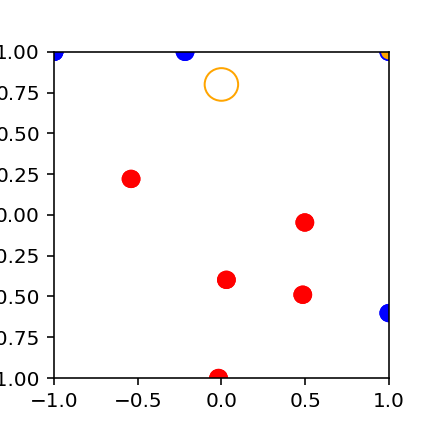

In [7]:
init_game_state = random_initial_game_state(batch_size=1)
all_game_states = run_simulation(model_o, model_d, init_game_state, pbar=tqdm())

loss_o, loss_d = loss_function(all_game_states)
print(f'O Loss: {loss_o.item()}, D Loss: {loss_d.item()}')


%matplotlib notebook
anim = show_game_animation(all_game_states)

In [8]:
batch_size = 19

opt_o = torch.optim.Adam(model_o.parameters())
opt_d = torch.optim.Adam(model_d.parameters())

losses_o, losses_d = [], []


total_pbar = tqdm(range(200), desc='Epochs')

for epoch in total_pbar:
    init_game_state = random_initial_game_state(batch_size=batch_size)
    
    all_game_states = run_simulation(model_o, model_d, init_game_state, with_grad=True)
    
    

    
    loss_o, loss_d = loss_function(all_game_states)

    opt_o.zero_grad()
    opt_d.zero_grad()
    grad_o = torch.autograd.grad(loss_o, model_o.parameters(), retain_graph=True)
    grad_d = torch.autograd.grad(loss_d, model_d.parameters())
    for i, params in enumerate(model_o.parameters()):
        params.grad = grad_o[i]
    for i, params in enumerate(model_d.parameters()):
        params.grad = grad_d[i]
    
    opt_o.step()
    opt_d.step()
    
    total_pbar.set_postfix({'O Loss': loss_o.item(), 'D Loss': loss_d.item()})
    losses_o.append(loss_o)
    losses_d.append(loss_d)
    

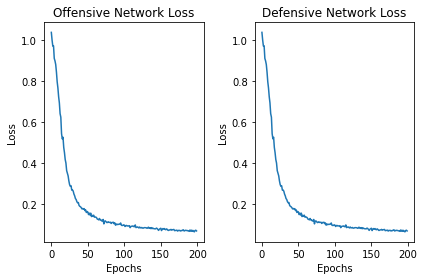

In [9]:
%matplotlib inline

plt.subplot(121)
plt.plot(np.arange(len(losses_o)), losses_o)
plt.title('Offensive Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(122)
plt.plot(np.arange(len(losses_d)), losses_d)
plt.title('Defensive Network Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

O Loss: 0.07314718514680862, D Loss: 0.07314718514680862



<IPython.core.display.Javascript object>


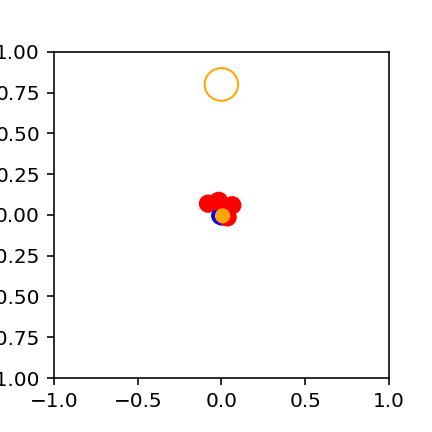

In [12]:
init_game_state = random_initial_game_state(batch_size=1)
all_game_states = run_simulation(model_o, model_d, init_game_state, pbar=tqdm())

loss_o, loss_d = loss_function(all_game_states)
print(f'O Loss: {loss_o.item()}, D Loss: {loss_d.item()}')


%matplotlib notebook
anim = show_game_animation(all_game_states)

# Loss Function Visuals

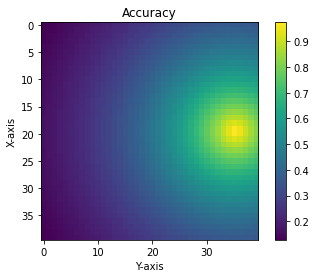

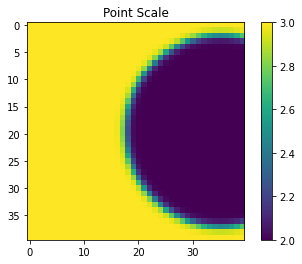

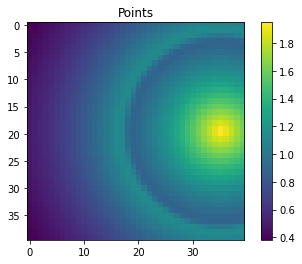

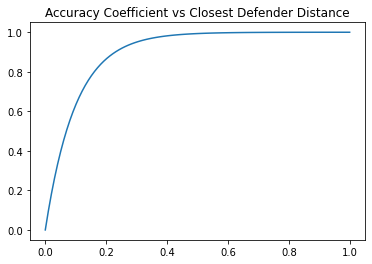

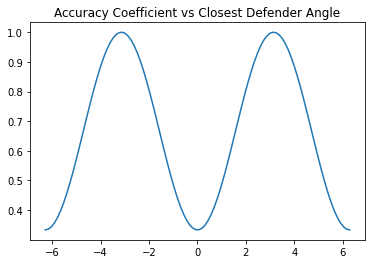

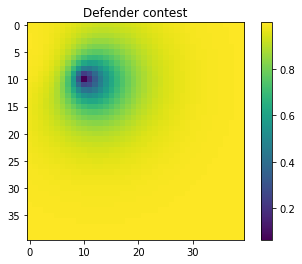

In [24]:
# general functions
def distance(pos, pos_base=pos_hoop):
    return (pos-pos_base).norm(dim=-1)
def direction(pos, pos_base=pos_hoop):
    locations = pos - pos_base
    theta = torch.atan2(locations[..., 1], locations[..., 0])
    return theta
def polar_coordinates(pos, pos_base=pos_hoop):
    return hoop_distance(pos, pos_base), hoop_direction(pos, pos_base)

# basketball functions
def raw_accuracy(pos, pos_base=pos_hoop):
    r = distance(pos, pos_base)
    accuracy = 1/torch.exp(r)
    return accuracy
def raw_points(pos, pos_base=pos_hoop):
    r = distance(pos, pos_base)
    point_scale = 2 + 1 / (1 + torch.exp(-50 * (r-0.9)))
    return point_scale

def raw_contest_distance(dist):
    return 1 - torch.exp(-10*dist)
def raw_contest_angle(theta):
    return (torch.cos(theta-np.pi)+2.)/3.

def raw_contest(pos_op, pos_dp, pos_base=pos_hoop):
    theta_hoop = direction(pos_op, pos_base)
    theta_defender = direction(pos_op, pos_dp)
    
    contest_directional = raw_contest_angle(theta_defender-theta_hoop)
    
    r = distance(pos_dp, pos_op)
    contest_distance = raw_contest_distance(r)
    
    a = contest_distance
    b = contest_distance*contest_directional
    weight = torch.tanh(2*r)
    return weight*a+(1-weight)*b

%matplotlib inline

resolution = 40
x, y = torch.meshgrid(torch.linspace(-1, 1, resolution), torch.linspace(-1,1, resolution))
pos_grid = torch.stack((x, y), dim=-1)


raw_acc = raw_accuracy(pos_grid)
plt.imshow(raw_acc.numpy())
plt.xlabel('Y-axis')
plt.ylabel('X-axis')
plt.title('Accuracy')
plt.colorbar()
plt.show()


ps = raw_points(pos_grid)
plt.imshow(ps.numpy())
plt.title('Point Scale')
plt.colorbar()
plt.show()


plt.imshow((ps*raw_acc).numpy())
plt.title('Points')
plt.colorbar()
plt.show()


d = torch.linspace(0, 1, 100)
contest = raw_contest_distance(d)
plt.plot(d.numpy(), contest.numpy())
plt.title('Accuracy Coefficient vs Closest Defender Distance')
plt.show()


d = torch.linspace(-2*np.pi, 2*np.pi, 100)
contest = raw_contest_angle(d)
plt.plot(d.numpy(), contest.numpy())
plt.title('Accuracy Coefficient vs Closest Defender Angle')
plt.show()

pos_op = torch.tensor([-0.5,-0.5])
contest = raw_contest(pos_op, pos_grid)
plt.imshow(contest.numpy())#, vmin=0, vmax=1)
plt.title('Defender contest')
plt.colorbar()
plt.show()




In [8]:
a = torch.tensor([1,2.,3,4], requires_grad=True)
b = torch.tensor([3,2.,0,8], requires_grad=True)

l1 = (a * b).sum()
l2 = (a**2 * b**2).sum()

print('True: ')
print(torch.autograd.grad(l1, a, retain_graph=True))
print(torch.autograd.grad(l2, b, retain_graph=True))

a.grad = None
b.grad = None
torch.autograd.backward([l1,l2])

print(a.grad)
print(b.grad)

True: 
(tensor([3., 2., 0., 8.]),)
(tensor([  6.,  16.,   0., 256.]),)
tensor([ 21.,  18.,   0., 520.])
tensor([  7.,  18.,   3., 260.])
